# __Convolutional Neural Network (CNN)__

- Convolutional neural networks or CNNs are a type of artificial neural network widely used for image-related tasks such as image classification or object detection. This is because, unlike traditional neural networks, which operate on tabular or flat data, CNNs are specifically designed to work with data that have a spatial structure. 

- The basic architecture of a CNN consists of a series of layers of different types:

    - __Convolutional layers:__ these are the distinguishing feature of CNNs, they serve to detect local patterns in the input data by applying convolution operations.
    
    - __Padding layers:__ they add zeros around the edges of the input data so that the output dimensions of the convolution operations are the same as the input ones. This ensures that the edge information is taken into account and no relevant data is lost.

    - __Pooling layers:__ reduce the dimensionality of the output of the convolution layer that precedes them, typically by selecting the maximum value of a sliding window. This serves to retain the most important features, which improves the generalizability of the model and thus helps prevent overfitting. 

- At the end of the CNN, there is a final layer known as the __Dense layer or Fully Connected Layer__, and it is responsible for performing the final classification of the model. Each neuron in this layer is connected to all neurons in the previous layer and applies an activation function, such as softmax in multiclass classification problems, to generate probabilities of membership in each class. The output of this layer is a vector of dimensions equal to the number of classes, where each element represents the probability of belonging to a specific class.

#### CNN for Text Classification

- Although their best known application is image processing, recently CNNs have also proven to be very effective in pattern recognition tasks on sequential data such as text. The main difference in use is the input dimensionality. When dealing with images, these can be 2-dimensional if they are grayscale images or 3-dimensional if they are RGB images. However, when dealing with text, the input is a one-dimensional vector. This vector, as we have already explained in previous models, is the result of tokenization (in which we assign an index to each word) and embedding (in which we convert each number into a fixed-size vector).

- The image below represents in a very basic way a cnn model for text classification. Specifically, to address a multiclass problem such as the one we are dealing with (but with 11 classes instead of 28).

![CNN for Text Multiclass Classification](../imgs/cnn.png)

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Custom libraries
import sys
sys.path.append('..')
from functions.models import *

### Load data

In [4]:
X_train = pd.read_csv('../data/X_train.tsv', sep='\t')
X_test = pd.read_csv('../data/X_test.tsv', sep='\t')
X_val = pd.read_csv('../data/X_val.tsv', sep='\t')

y_train = pd.read_csv('../data/y_train.tsv', sep='\t')
y_test = pd.read_csv('../data/y_test.tsv', sep='\t')
y_val = pd.read_csv('../data/y_val.tsv', sep='\t')

# Check
print(X_train.head())
print(y_train.head())

                                             comment
0                                               fuck
1                               make feel threatened
2                              dirty southern wanker
3  omg good enough help u playoff dumbass bronco ...
4                 yes heard f bomb thanks reply wait
   label
0      2
1     14
2      3
3     26
4     15


### Tokenization, Padding and Sequencing

In [5]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val, "comment")

### Model Building

In [6]:
# List of emotions
cat_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]
num_labels = len(cat_labels)

# Convert labels to a format suitable for training
y_train_categorical = to_categorical(y_train, num_classes=num_labels)
y_test_categorical = to_categorical(y_test, num_classes=num_labels)
y_val_categorical = to_categorical(y_val, num_classes=num_labels)

In [7]:
# Create el modelo
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=200, input_length=max_seq_len))

# Convolutional layers
model.add(Conv1D(filters=100, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))

# Flatten and classifier
model.add(Flatten())
model.add(Dropout(0.7))
model.add(Dense(128, activation="relu"))

# Output layer
model.add(Dense(num_labels, activation="softmax"))  # Usar softmax para clasificación múltiple

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           1188800   
                                                                 
 conv1d (Conv1D)             (None, 20, 100)           100100    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 100)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                        

### Model Training

In [8]:
# Define EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)
mc = ModelCheckpoint(filepath='../trained_models/cnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Train the model
history = model.fit(
    train_padded, y_train_categorical,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, y_val_categorical),
    callbacks=[es, mc]
)

Epoch 1/50
557/559 [============================>.] - ETA: 0s - loss: 2.9344 - accuracy: 0.1556
Epoch 1: val_loss improved from inf to 2.54961, saving model to ../trained_models\cnn.h5
559/559 [==============================] - 15s 26ms/step - loss: 2.9346 - accuracy: 0.1556 - val_loss: 2.5496 - val_accuracy: 0.2924
Epoch 2/50
556/559 [============================>.] - ETA: 0s - loss: 2.6054 - accuracy: 0.2579
Epoch 2: val_loss improved from 2.54961 to 2.38898, saving model to ../trained_models\cnn.h5
559/559 [==============================] - 13s 23ms/step - loss: 2.6050 - accuracy: 0.2580 - val_loss: 2.3890 - val_accuracy: 0.3493
Epoch 3/50
558/559 [============================>.] - ETA: 0s - loss: 2.4342 - accuracy: 0.3034
Epoch 3: val_loss improved from 2.38898 to 2.28702, saving model to ../trained_models\cnn.h5
559/559 [==============================] - 12s 22ms/step - loss: 2.4341 - accuracy: 0.3034 - val_loss: 2.2870 - val_accuracy: 0.3735
Epoch 4/50
557/559 [==================

### Model Validation

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

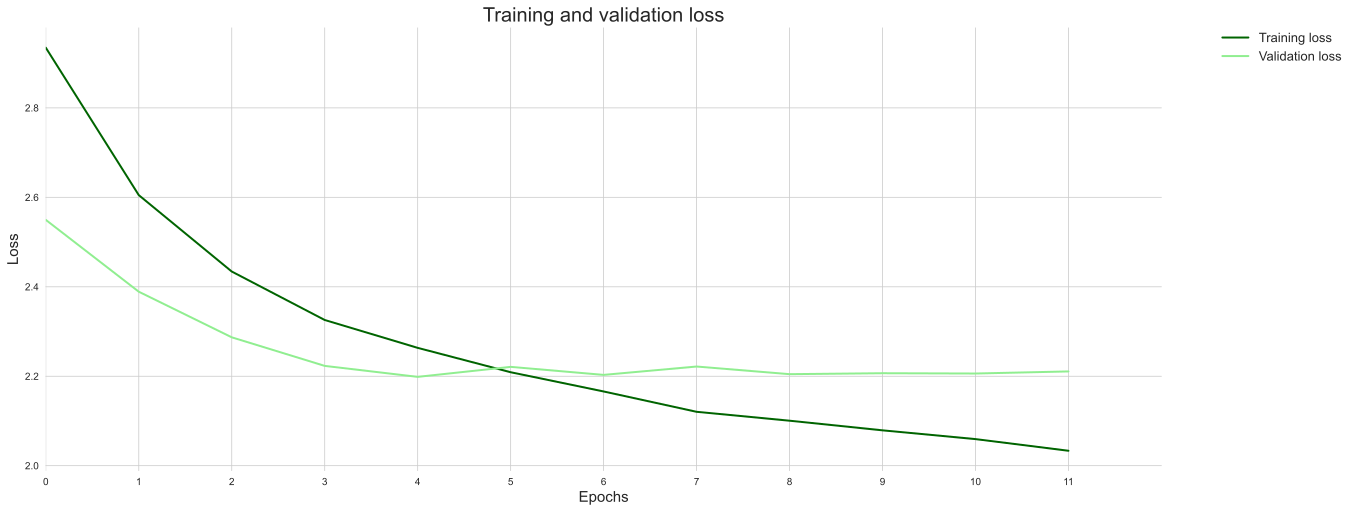

In [10]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkgreen", "lightgreen", "Loss", 1)

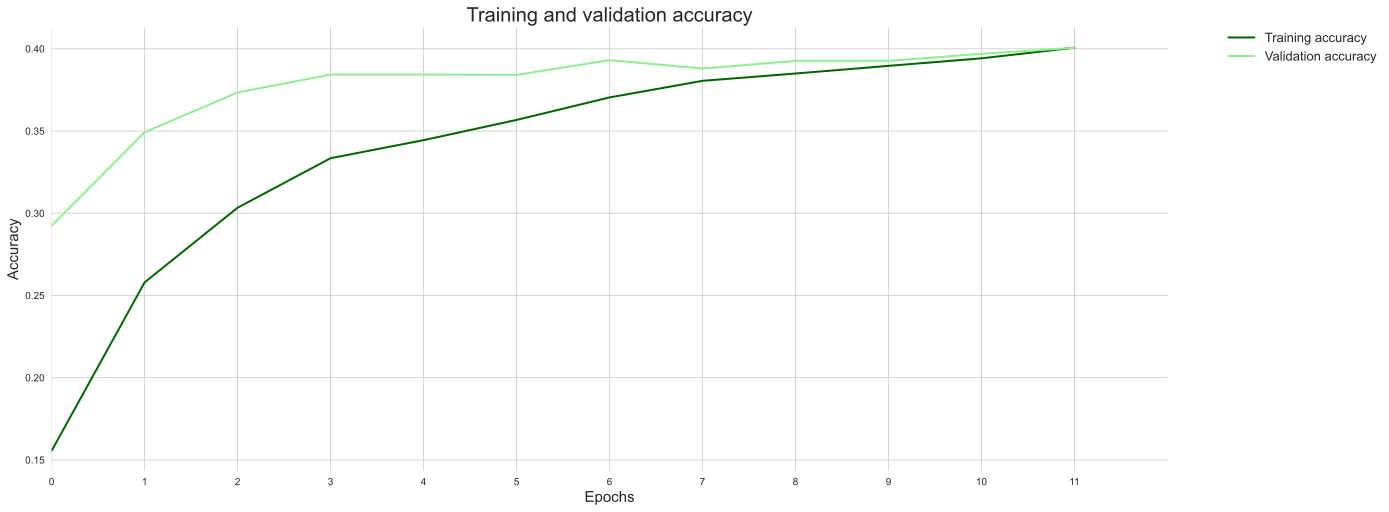

In [11]:

# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkgreen", "lightgreen", "Accuracy", 1)

- We see that the training process has lasted 11 epochs. Therefore, since we set a patience of 7, this means that the model did not improve after the 4th epoch. 

- In fact, we see that in the 4th epoch the validation loss reaches its minimum point, while the training loss continues to decrease. The loss considered optimal is 2.22 (crossover point of training and validation loss, shortly before reaching the 5th epoch).

- On the other hand, the best accuracy is reached in the last epoch, since until then the training accuracy does not meet the validation accuracy. This is because the training accuracy improves more slowly than the validation accuracy.

### Model Evaluation

In [12]:
# Apply tokenizer to test set
test_sequences = tokenizer.texts_to_sequences(X_test["comment"])
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

In [13]:
cnn_model = load_model('../trained_models/cnn.h5')

In [14]:
# Evaluate model on test set
loss_test, acc_test = cnn_model.evaluate(test_padded, np.array(y_test_categorical))
print("Test loss: {:.4f}".format(loss_test))  
print("Test accuracy: {:.4f}".format(acc_test))

140/140 [==============================] - 1s 3ms/step - loss: 2.2230 - accuracy: 0.3765
Test loss: 2.2230
Test accuracy: 0.3765


In [15]:
# Get real labels in a NumPy array
real_labels = y_test['label'].values
len(real_labels)

4467

In [16]:
# Get predicted labels in a NumPy array
predictions = cnn_model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)
len(predicted_labels)

140/140 [==============================] - 1s 4ms/step


4467

In [17]:
len(cat_labels)

28

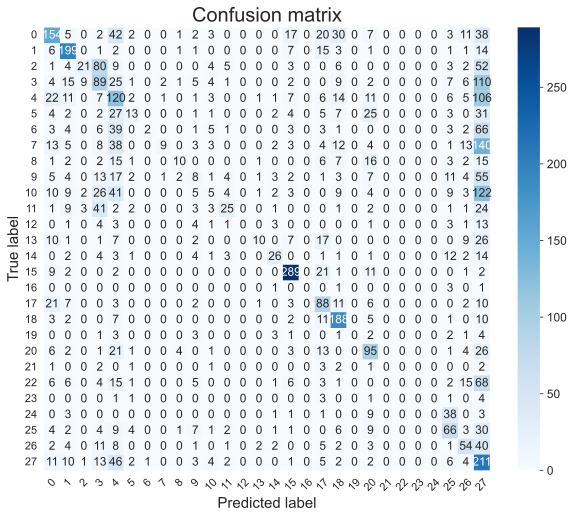

In [18]:
# Plot confusion matrix
unique_labels = np.unique(real_labels)
plot_confusion_matrix(real_labels, predicted_labels, unique_labels, cmap="Blues")

- The confusion matrix reminds us very much of the one obtained with the LSTM, with a diagonal marked by dark values and a very good rate of success in labeling emotions as 1 (aumusement) and 15 (gratitude).

- However, we appreciate darker tones in vertical 27, which indicates that many comments have been erroneously labeled as 27 (neutral). The same occurs with 4 (approval) although to a lesser extent.